# TF-IDF

Today's topic is term frequency inverse document frequency, which is a statistic for estimating the importance of words and phrases in a set of documents.

## Example

As an example, I've been tracking ...

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import twython
import time
import ConfigParser
from collections import defaultdict

In [16]:
propertiesFile = "my.properties"
cp = ConfigParser.ConfigParser()
cp.readfp(open(propertiesFile))

APP_KEY            = cp.get('Params', 'app_key')
APP_SECRET         = cp.get('Params', 'app_secret')
OAUTH_TOKEN        = cp.get('Params', 'oauth_token')
OAUTH_TOKEN_SECRET = cp.get('Params', 'oauth_token_secret')

twitter = twython.Twython(APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

In [3]:
files = os.listdir('.')
followers = {}
for file in files:
    i = file.find('_followers.txt')
    if i > 0:
        f = open(file, 'r')
        followers[file[0:i]] = set(f.read().split('\n'))
        f.close()

In [4]:
keys = followers.keys()
keys.sort()
unfollowers = []
allfollowers = set()
for i in range(len(keys)-1):
    today = followers[keys[i]]
    allfollowers = allfollowers.union(today)
    tomorrow = followers[keys[i+1]]
    unfollow = today.difference(tomorrow)
    unfollowers.extend(list(unfollow))

In [5]:
fol = random.sample(allfollowers, len(unfollowers))
nfol = unfollowers

In [6]:
follower_tweets = {}
unfollower_tweets = {}

In [21]:
errors = defaultdict(int)
for u in fol:
    try:
        follower_tweets[u]
    except KeyError:
        try:
            tweets = twitter.get_user_timeline(screen_name=u)
            all = []
            for tweet in tweets:
                all.append(tweet['text'])
            follower_tweets[u] = all
        except twython.TwythonError as e:
            if e.msg.find('Twitter API returned a 404 (Not Found)') == 0:
                ignoreDeletedAccount = True
            else:
                errors[e.msg] += 1
        time.sleep(5)
print errors

defaultdict(<type 'int'>, {'Twitter API returned a 401 (Unauthorized), An error occurred processing your request.': 9})


In [23]:
errors = defaultdict(int)
for u in nfol:
    try:
        unfollower_tweets[u]
    except KeyError:
        try:
            tweets = twitter.get_user_timeline(screen_name=u)
            all = []
            for tweet in tweets:
                all.append(tweet['text'])
            unfollower_tweets[u] = all
        except twython.TwythonError as e:
            if e.msg.find('Twitter API returned a 404 (Not Found)') == 0:
                ignoreDeletedAccount = True
            else:
                errors[e.msg] += 1
        time.sleep(5)
print errors

defaultdict(<type 'int'>, {'Twitter API returned a 401 (Unauthorized), An error occurred processing your request.': 30})


In [26]:
import pickle
pickle.dump({'unfollower_tweets': unfollower_tweets, 'follower_tweets': follower_tweets}, open('tfidfbackup.pkl', 'wb'))

In [2]:
import pickle
x = pickle.load(open('tfidfbackup.pkl', 'rb'))
unfollower_tweets = x['unfollower_tweets']
follower_tweets = x['follower_tweets']

In [5]:
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

docs = unfollower_tweets.values()
docs.extend(follower_tweets.values())

tokens = set()
for tdocs in docs:
    for doc in tdocs:
        doc = doc.lower()
        dtokens = tokenize(doc)
        tokens = tokens.union(dtokens)

LookupError: 
**********************************************************************
  Resource u'tokenizers/punkt/english.pickle' not found.  Please
  use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/home/deploy/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - u''
**********************************************************************

In [6]:
import gensim

In [ ]:
dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            "mtsamples.dict"))
corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, "mtsamples.mm"))

tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

# write out coordinates to file
fcoords = open(os.path.join(MODELS_DIR, "coords.csv"), 'wb')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

In [40]:
cleaned

[u'@faithandfaders oh gordon.',
 u'@peterrylands @wundershqip ha!!',
 u"we're recording a christmas episode tonight, what should we talk about? #podcast",
 u"rt @oliversnelling: @pip_wall do you listen to my podcast?! second to @serial i'd say @talking_podcast is the next addictive hyped podcast \u2026",
 u"here's a little video from us for today... https://t.co/ulstbbbfb6",
 u'sadly there is no episode today but ollie has an update for you... \n\nhttps://t.co/jd4goejplq',
 u"sorry we forgot to let you know yesterday - but sadly this week's #talkingfact was false. @lexlowmusic was not in s club juniors.",
 u'have a look at our afternoon with @mattvbray https://t.co/viwxzpipvb https://t.co/yilbhjnj0s',
 u"our guest @lexlowmusic was an absolute delight, you'll love him and his music. \n\nenjoy.\n\nhttps://t.co/6hde6kvsl3 https://t.co/466fsgrj2l",
 u'joseph listened to @lexlowmusic for the first time during the tea break. \n\nyou should too. \n\nhttps://t.co/6hde6kvsl3 https://t.co/8nxr4r

In [ ]:
token_dict = {}
stemmer = PorterStemmer()

#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())

In [21]:
import random
random.random()

0.034844596428449615

In [110]:
import random
import math
tokens = ['adf', 'klj', 'iuaod', 'ssfle', 'edfel', 'egfel', 'efhlef', 'efjlef', 'sokeof', 'adf', 'adffd', 'f', 'ff', 'fff', 'ffff', 'fffff', 'fa', 'faa', 'faaa']
w = []
for t in tokens:
    r = math.pow(random.random(), 3)
    w.append(r)
w = np.array(w)
w = w / sum(w)
df = pd.DataFrame({'token': tokens, 'w': w})
df.sort('w', inplace=True, ascending=True)
df.index = np.arange(df.shape[0]) + 1

In [130]:
if df.shape[0] > 10:
    tail = df.ix[:10, 'w'].sum()
    rem = df.iloc[10:].copy()
    rem.sort('w', inplace=True, ascending=False)
    rem.ix[rem.shape[0]] = pd.Series({'token': '--[other terms]--', 'w': tail})
    rem.index = np.arange(rem.shape[0])

In [131]:
rem

,token,w
0,fa,0.182045
1,faa,0.173771
2,adf,0.148007
3,ssfle,0.139892
4,ff,0.101003
5,klj,0.058918
6,ffff,0.055602
7,egfel,0.032608
8,fffff,0.029047
9,--[other terms]--,0.079108


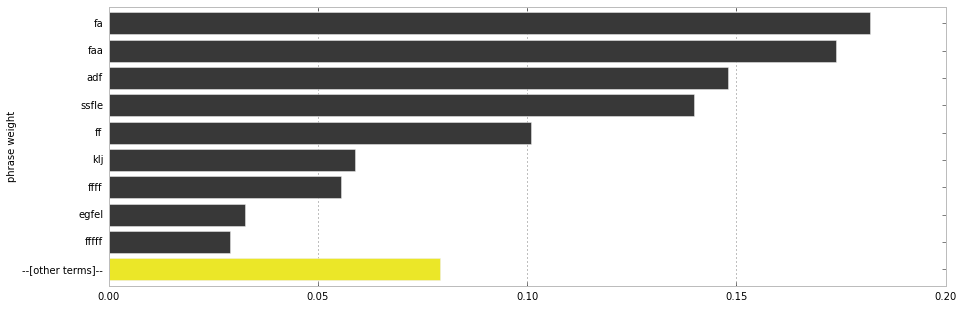

In [163]:
plt.figure(figsize=(15,5))
colors = []
for c in range(rem.shape[0]-1):
    colors.append('#383838')
colors.append('#ebe728')
plt.barh(rem.index * -1, rem['w'], color=colors)
plt.gca().yaxis.grid(False)
plt.yticks(rem.index * -1 + 0.4, rem['token'])
plt.ylim(-1 * rem.shape[0] + 0.8, 1)
plt.ylabel('phrase weight')
plt.show()